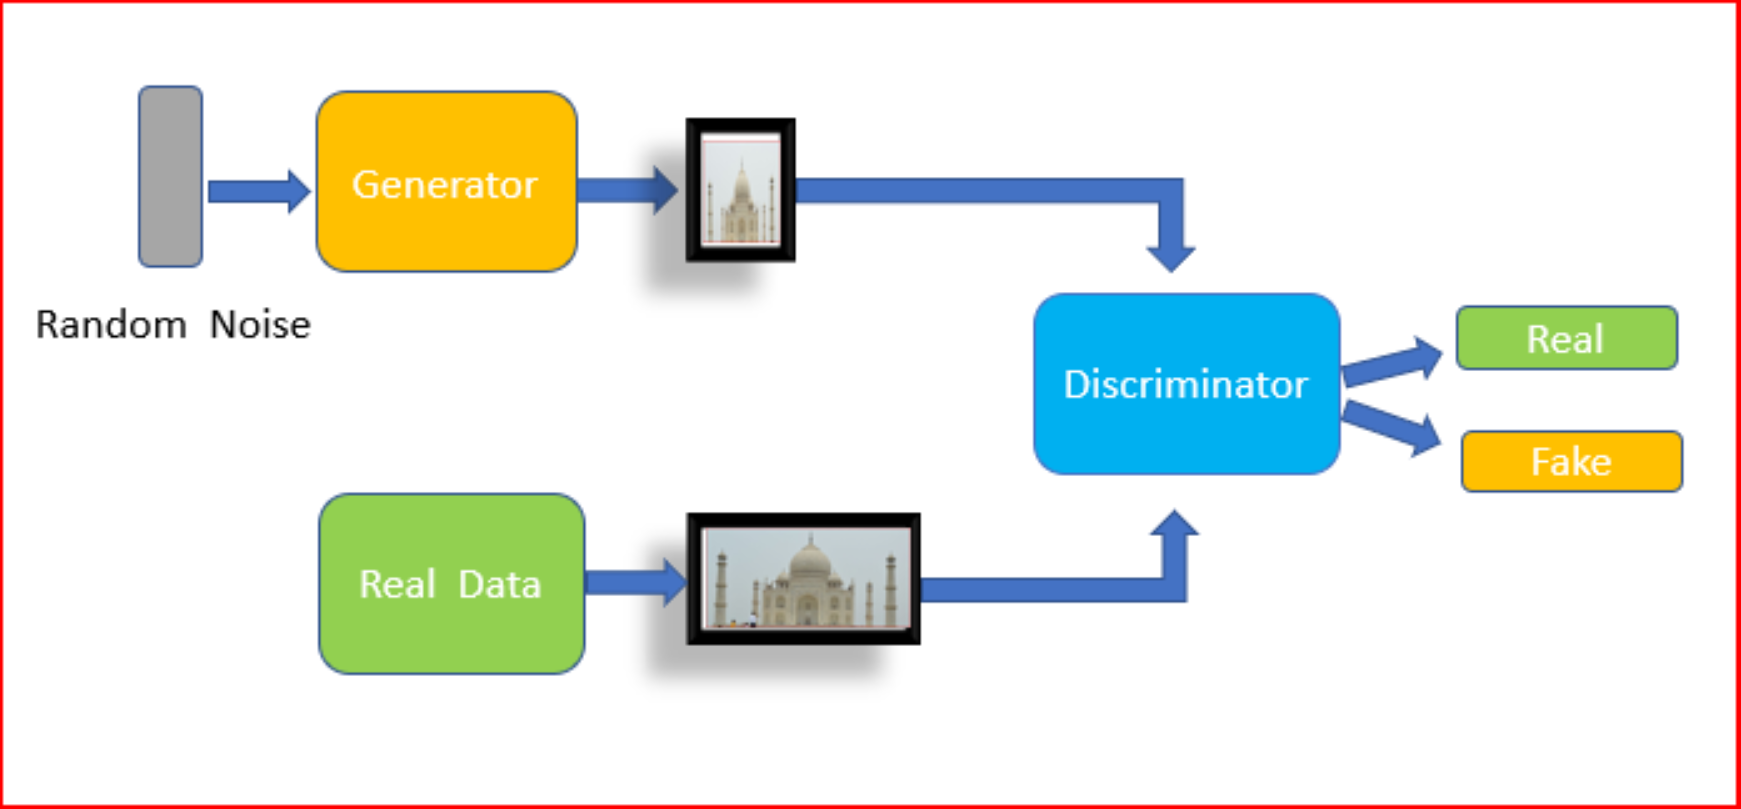

In [1]:
import numpy as np
import keras
import tensorflow as tf 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
(X_train,_),(_,_)=keras.datasets.fashion_mnist.load_data()
print('X_train Shape :',X_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
X_train Shape : (60000, 28, 28)


In [3]:
#normlize between -1,1
X_train=(X_train-127.5)/127.5
X_train=np.expand_dims(X_train,axis=-1)
print('X_train Shape :',X_train.shape)

X_train Shape : (60000, 28, 28, 1)


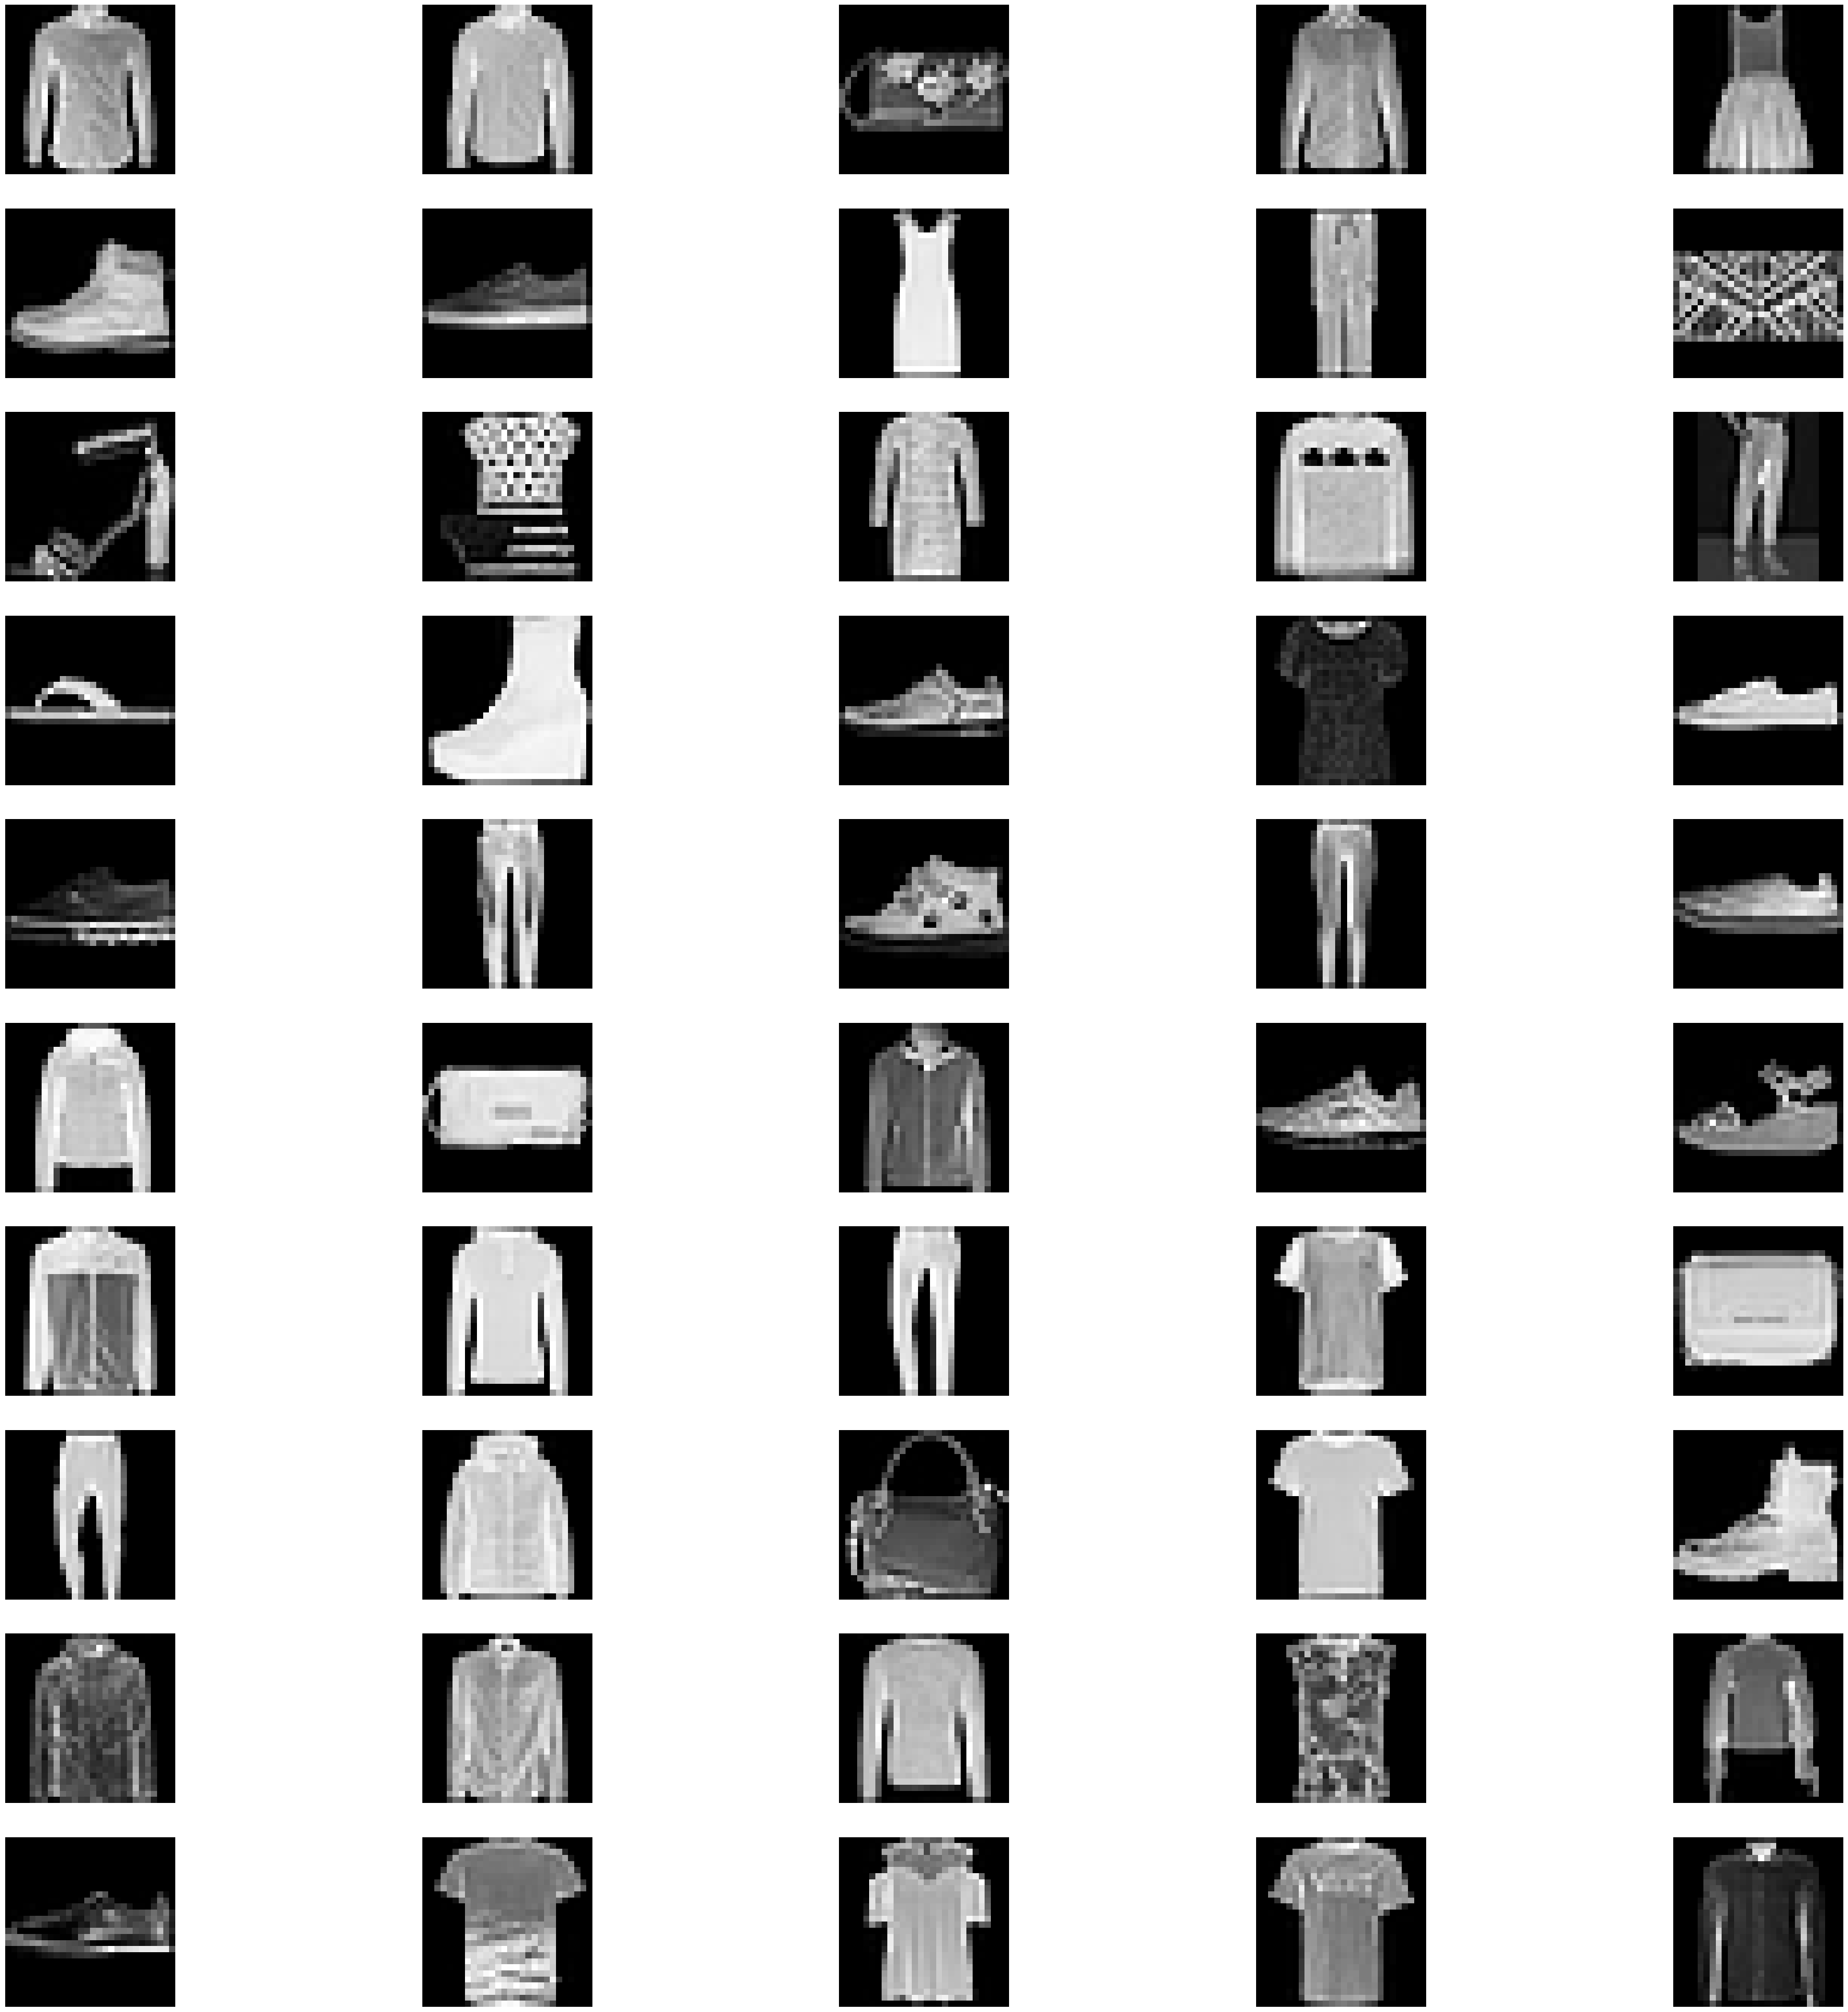

In [4]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(X_train),50)):
    plt.subplot(10,5,n+1)
    plt.imshow(X_train[i],'gray')
    plt.axis('off')

In [5]:
def generator_model():
    model=keras.Sequential()
    model.add(keras.layers.Dense(256 * 7 * 7, input_dim=100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Reshape((7, 7, 256)))
    model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same',use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Conv2DTranspose(1, (5, 5),strides=(2,2), padding='same',activation='tanh'))
    return model

In [6]:
generator=generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

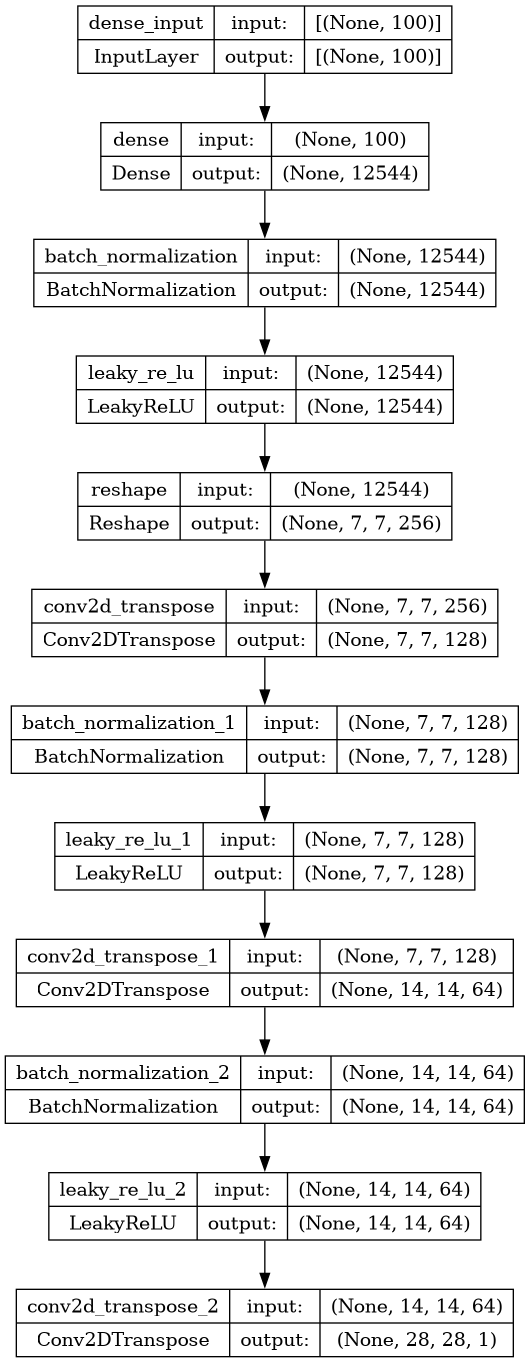

In [7]:
keras.utils.plot_model(generator,show_shapes=True)

In [8]:
def discriminator_model():
    model=keras.Sequential()
    model.add(keras.layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Conv2D(128,(5,5),strides=(2,2),padding='same',activation='relu'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1,activation='tanh'))
    return model

In [9]:
discriminator=discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

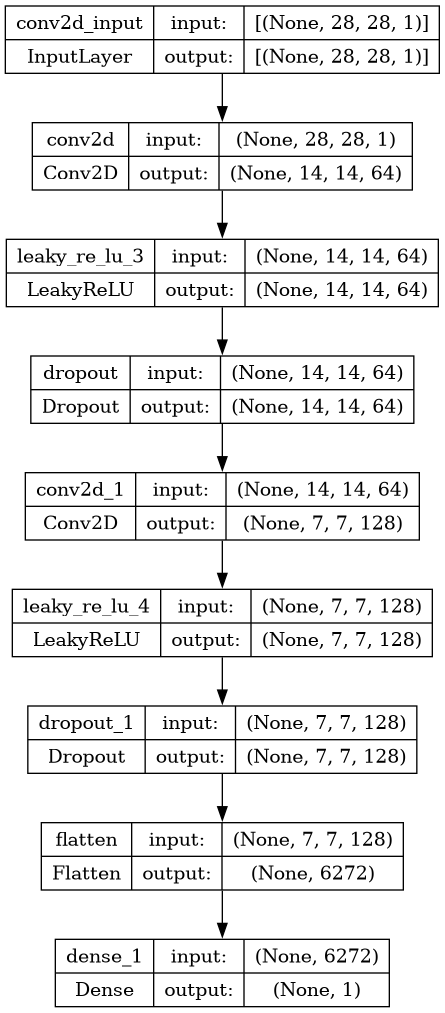

In [10]:
keras.utils.plot_model(discriminator,show_shapes=True)

In [11]:
loss=keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
    return loss(tf.ones_like(fake_output), fake_output)
def discriminator_loss(real_output, fake_output):
    real_loss = loss(tf.ones_like(real_output), real_output)
    fake_loss = loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

In [13]:
gen_l,dis_l=[],[]
def train_step(images):
    fake_img_noise = tf.random.normal([256, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(fake_img_noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        gen,dis=np.mean(gen_loss),np.mean(disc_loss)
        gen_l.append(gen)
        dis_l.append(dis)

In [14]:
def train(dataset,epochs):
    for epoch in range(epochs):
        print('Number Of Epoch is :',epoch)
        for batch in dataset:
            train_step(batch)
        print("gen_loss" , np.mean(gen_l))
        print("disc_loss" , np.mean(dis_l))

In [15]:
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=60000).batch(256)

In [16]:
for ba in dataset:
    print(ba.shape)

(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 1)
(256, 28, 28, 

In [17]:
train(dataset,50)

Number Of Epoch is : 0
gen_loss 0.78252566
disc_loss 1.207447
Number Of Epoch is : 1
gen_loss 0.8157481
disc_loss 1.1940185
Number Of Epoch is : 2
gen_loss 0.81025857
disc_loss 1.2269099
Number Of Epoch is : 3
gen_loss 0.83730716
disc_loss 1.2689321
Number Of Epoch is : 4
gen_loss 0.8373011
disc_loss 1.2672336
Number Of Epoch is : 5
gen_loss 0.8383182
disc_loss 1.2669619
Number Of Epoch is : 6
gen_loss 0.84205484
disc_loss 1.2567216
Number Of Epoch is : 7
gen_loss 0.8457704
disc_loss 1.2454072
Number Of Epoch is : 8
gen_loss 0.8525835
disc_loss 1.2384077
Number Of Epoch is : 9
gen_loss 0.86119825
disc_loss 1.2258298
Number Of Epoch is : 10
gen_loss 0.86966974
disc_loss 1.2157341
Number Of Epoch is : 11
gen_loss 0.877094
disc_loss 1.2051605
Number Of Epoch is : 12
gen_loss 0.8863521
disc_loss 1.1948086
Number Of Epoch is : 13
gen_loss 0.89565045
disc_loss 1.1826539
Number Of Epoch is : 14
gen_loss 0.9038536
disc_loss 1.1736938
Number Of Epoch is : 15
gen_loss 0.9116922
disc_loss 1.16325

In [18]:
a = np.random.randn(50,100)
a.shape

(50, 100)

In [19]:
predictions=generator(a)

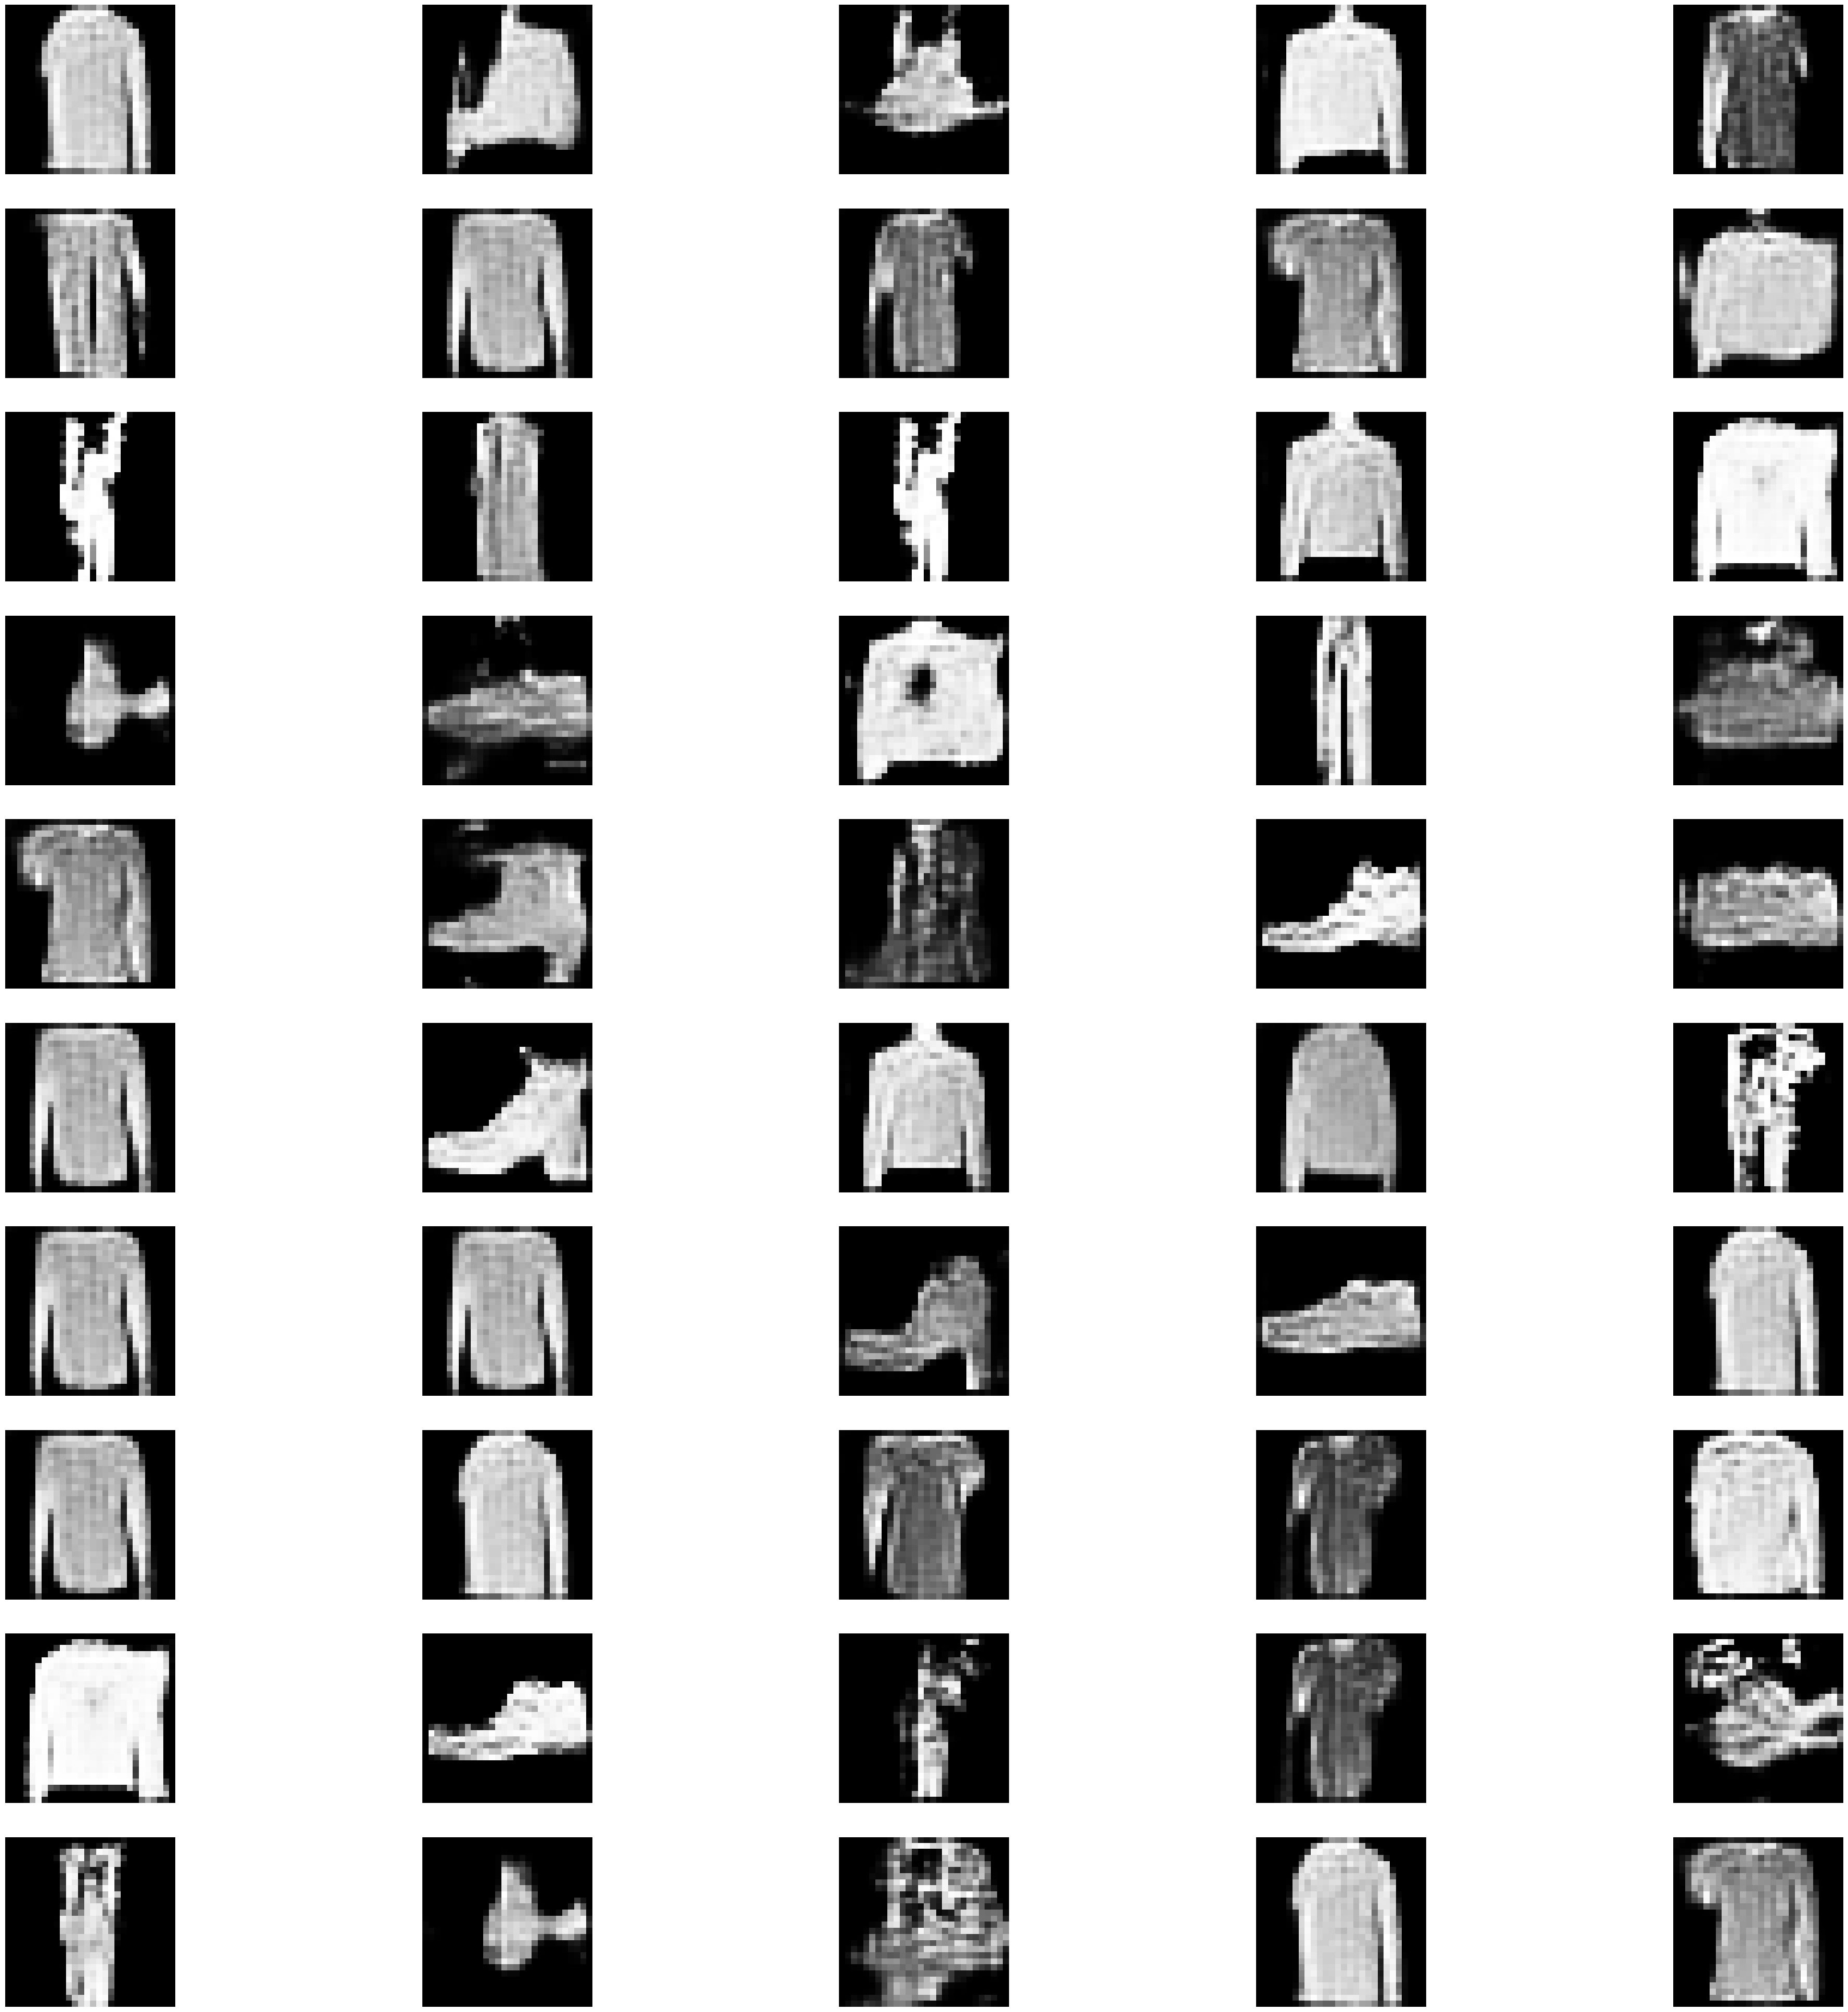

In [20]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,50,50)):
    plt.subplot(10,5,n+1)
    plt.imshow(predictions[i]*127.5+127.5,'gray')
    plt.axis('off')

In [21]:
generator.save('generator.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
